# Figure 3: Birth-death steady-state variability
This notebook generates Figure 3 of 'Moment-based analysis of biochemical feedback circuits in a population of chemically interacting cells' (https://arxiv.org/abs/1905.02053). Steady-state (t = 1000) lower-order moments of a heterogeneous population of communicating cells containing a birth-process are calculated using a symmetry-reduced model and compared with stochastic simulation results. 

## Load required libraries
We use the packages Tellurium (https://tellurium.analogmachine.org) and Sympy (https://sympy.org) to setup the symmetry-reduced model and Tellurium to run stochastic simulations. 

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import pandas as pd
import tellurium as te
import itertools
import sympy
from sympy import symbols
from sympy.parsing.sympy_parser import parse_expr
from scipy.integrate import odeint
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Set figure formatting

In [2]:
matplotlib.rcParams['axes.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14
matplotlib.rcParams['axes.titlesize'] = 18
matplotlib.rcParams['lines.linewidth'] = 1.5
matplotlib.rcParams['legend.fontsize'] = 14
matplotlib.rcParams['axes.titlepad'] = 10

## Load Tellurium and symmetry-reduced moment functions
**writeAnt.py** contains functions to write down Antimony files for different reaction networks of communicating cell popuations to run in Tellurium. **GenerateReducedMoments.py** contains functions to setup and solve moment equations of reaction networks (given as Antimony files).

In [3]:
%run GenerateReducedMoments.py
%run writeAnt.py

## Write antimony file
Use the **writeBirthDeath** function in writeAnt.py to generate a reaction network of 2 communicating cells containing a birth-death process.

In [4]:
writeBirthDeath(np.zeros((2,2)), np.zeros((2,4)), 2)

## Load reaction network and get moment equations
The net stoichiometry matrix (including rate reaction parameters) derived from the Antimony file is used to setup moment dynamics equations.

In [5]:
# Set antimony file path.
path = 'birthdeath.ant'

# Get reaction network info.
keys, net_stoich = getReactionInfo(path)
rate_laws = getRateLaws(path)

# Remove rate parameters that are considered constant homogeneous.
new_keys = []
new_net_stoich = np.zeros(np.shape(net_stoich)[1])
kouts = ['kout'+str(i) for i in range(2)]
kins = ['kin'+str(i) for i in range(2)]
kds = ['kd'+str(i) for i in range(2)]
ks = kouts+kins+kds
for idx,i in enumerate(keys):
    if i not in ks:
        new_keys.append(i)
        new_net_stoich = np.vstack((new_net_stoich,net_stoich[idx,:]))
new_net_stoich = new_net_stoich[1:,:]

# Load symbolic variables.
symbols_dict = dict(zip(keys, symbols(keys)))
locals().update(symbols_dict)

# Get moment equations.
M, moments, moment_idx = getMoments(new_net_stoich, rate_laws, new_keys)

## Solve moment dynamics
Here we solve moment dynamics as a system of ODEs with **odeint** for different population sizes and coupling strengths. The number of equations to solve is independent of the population size. In the paper, we say that the number of equations is:

\begin{equation}
\hat{K}_{eq} = 4S+2+\binom{2S+2M+1}{2}-\binom{2M}{2}
\end{equation}

However, in this implementation, we include equations for reaction rate parameters as well to allow the possibility of using time-varying reaction rate parameters. This makes the number of equations:

\begin{equation}
\hat{K}_{eq} = 4S+4M+2+\binom{2S+2M+1}{2}
\end{equation}

Because of population heterogeneity, the system of ODEs are non-closed and we use Gaussian or Lognormal moment-closure approximations. If you use the Lognormal moment-closure approximation, the initial conditions should have non-zero mean values!

In [6]:
# This function calculates the initial 1st and 2nd order moments of species 
# and heterogeneous rate parameters given their initial mean and stdev.
def setInitialConditions(mu, i_mean, i_std, k_mean, k_std):
    mu_dict = { '(P0, 1)': i_mean[0],
                '(P0, 2)': i_std[0]**2+ i_mean[0]**2,
                '(P1, 1)': i_mean[0],
                '(P1, 2)': i_std[0]**2+ i_mean[0]**2,
                '(Ss, 1)': i_mean[1],
                '(Ss, 2)': i_std[1]**2+ i_mean[1]**2,
                '(kb0, 1)': k_mean[0], 
                '(kb0, 2)': k_std[0]**2+ k_mean[0]**2, 
                '(kb1, 1)': k_mean[0], 
                '(kb1, 2)': k_std[0]**2+ k_mean[0]**2 }
    mu_0 = getInitialConditions(mu, mu_dict)
    return mu_0

# This function substitutes the symbolic variables of the homogeneous 
# constant reaction rate parameters.
def array_sub(array, k_mean, kd0, kd1, kout0, kin0, kout1, kin1):
    arr_sub = np.zeros(np.shape(array))
    for i, row in enumerate(array):
        for j, col in enumerate(row):
            if col != 0:
                # change rate constant values here!
                arr_sub[i, j] = col.subs([(kd0, k_mean[1]),
                                          (kd1, k_mean[1]),
                                          (kout0, k_mean[2]), 
                                          (kin0, k_mean[3]), 
                                          (kout1, k_mean[2]), 
                                          (kin1, k_mean[3])])
    return arr_sub

# Set number of cells in the population.
N = 10

# List of the coupling strengths of the cells in the population to test.
k_list = [0, 0.01, 0.1, 1]

# List of the variability (stdev) of birth reaction rate parameter to test.
std_list = [0, 0.25, 0.5, 0.75, 1]

# Time of simulation.
t = np.linspace(0, 1000, 100)

# Solve moment dynamics.
u_stack = np.zeros(len(moments))
labels = np.zeros(2)
for std in std_list:
    for k in k_list:
        # P, Ss
        i_mean = np.array([20, 0]) 
        i_std = np.array([5, 0])
        # kb, kd, kout, kin
        k_mean = np.array([1, 0.01, k, k])
        k_std = np.array([std, 0, 0, 0])
        # get community effect
        pop_moments = getCommunityEffect(N, moments, moment_idx, Ss, kout0, kin0, kout1, kin1)
        # get moments in matrix form
        moment_mat = getMomentMatrix(M, pop_moments, new_keys)
        # split into closed and non-closed portions
        A_df = moment_mat.iloc[:, ::-1].iloc[:, 0:len(pop_moments)]
        B_df = moment_mat.iloc[:, ::-1].iloc[:, len(pop_moments):]
        B_df = B_df.loc[:, (B_df != 0).any(axis = 0)]
        # replace rate parameters
        A_arr = np.array(A_df)
        A_sub = array_sub(A_arr, k_mean, 'kd0', 'kd1', 'kout0', 'kin0', 'kout1', 'kin1')
        B_arr = np.array(B_df)
        B_sub = array_sub(B_arr, k_mean, 'kd0', 'kd1', 'kout0', 'kin0', 'kout1', 'kin1')
        # moment closure
        mu = [i for i in A_df.columns]
        mu_bk = getClosureKey(B_df.columns)
        mu_0 = setInitialConditions(mu, i_mean, i_std, k_mean, k_std)
        u = odeint(derivativeGaussian, mu_0, t, args = (A_sub, B_sub, mu_bk, mu))
        #u = odeint(derivativeLognormal, mu_0, t, args = (A_sub, B_sub, mu_bk, mu))
        u_stack = np.vstack((u_stack,u))    
        labels = np.vstack((labels,np.array([k,std])))
u_stack = u_stack[1:,:]
labels = labels[1:,:]

## Format results and calculate CV
Convert to pandas dataframe and calculate CV and PV (pairwise variance).

In [7]:
u_df = pd.DataFrame(u_stack, columns=mu)
u_df.index = np.tile(t,len(k_list)*len(std_list))
u_df['Time'] = np.tile(t,len(k_list)*len(std_list))
u_df['k'] = np.tile(np.repeat(k_list, len(t)),len(std_list))
u_df['std'] = np.repeat(std_list, len(k_list)*len(t))
u_df['Std(P0)'] = ((u_df['P0**2']-u_df['P0']**2))**0.5
u_df['Std(P1)'] = ((u_df['P1**2']-u_df['P1']**2))**0.5
u_df['Std(Ss)'] = ((u_df['Ss**2']-u_df['Ss']**2))**0.5
u_df['CV(P0)'] = u_df['Std(P0)']/u_df['P0']
u_df['Var(P0-P1)'] = (2*u_df['P0**2']-2*u_df['P0*P1'])
u_df['Var(P0)'] = u_df['P0**2']-u_df['P0']**2
endpt = u_df[(u_df.index==1000)] # Where we get 'steady-state' value

## Run SSA for comparison
Use stochastic simulations to check and compare moments determined from symmetry-reduced model.

In [8]:
# This function runs multiple stochastic simulations using Tellurium.
def runSSA(std, k, runs):
    N = 10
    # P, Ss
    i_mean = np.array([20, 0]) 
    i_std = np.array([5, 0])
    # kb, kd, kout, kin
    k_mean = np.array([1, 0.01, k, k])
    k_std = np.array([std, 0, 0, 0])
    s_stack = np.zeros(N+2)
    for i in range(runs):
        initials = np.random.normal(i_mean,i_std, size = (N,len(i_mean)))
        rates = np.random.normal(k_mean,k_std, size = (N,len(k_mean)))
        writeBirthDeath(initials.astype(int), rates, N)
        path = 'birthdeath.ant'
        r = te.loada(path)
        r.integrator = 'gillespie'
        selections = ['time'] + r.getFloatingSpeciesIds()
        r.integrator.variable_step_size = False
        r.resetToOrigin()
        s = r.simulate(0, 1000, 100, selections=selections)
        s_stack = np.vstack((s_stack, s))
    s_stack = s_stack[1:]
    s_stack_df = pd.DataFrame(s_stack, columns = s.colnames)
    s_stack_df['std'] = np.repeat(std,runs*100)
    s_stack_df['k'] = np.repeat(k,runs*100)
    return s_stack_df

s_df = pd.DataFrame()
for k in [0, 0.01, 0.1, 1]:
    s_stack_df = runSSA(0.5, k, 100) # For 100 runs.
    s_df = s_df.append(s_stack_df, sort='True')

## Save compiled results

In [9]:
u_df.to_csv('birthdeath_ext_moments.csv', sep = ';')
s_df.to_csv('birthdeath_ext_ssa.csv', sep = ';')

Open the saved output files to avoid re-running SSAs.

In [10]:
s_df = pd.DataFrame.from_csv('birthdeath_ext_ssa.csv', sep = ';')
u_df = pd.DataFrame.from_csv('birthdeath_ext_moments.csv', sep = ';')

/Users/gonzales/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning:

from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls

/Users/gonzales/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning:

from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls



## Plot SSA vs. symmetry-reduced model moments

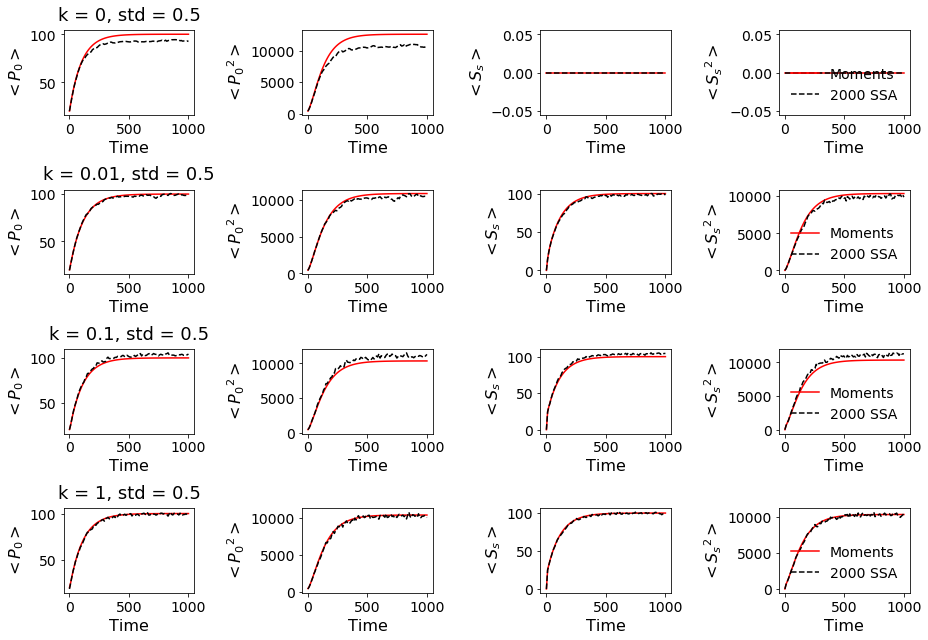

In [11]:
count = 0
plt.figure(figsize=(13,9))
for k in [0, 0.01, 0.1, 1]:
    std = 0.5
    sub_u = u_df[(u_df['std']==std) & (u_df['k']==k)]
    sub_s = s_df[(s_df['std']==std) & (s_df['k']==k)]
    mean_s = sub_s.groupby('time').mean()
    var_s = (sub_s.groupby('time').std())**2+(sub_s.groupby('time').mean())**2
    plt.subplot(4,4,count+1)
    plt.plot(sub_u['Time'], sub_u['P0'], 'r')
    plt.plot(mean_s.index, mean_s['P0'], linestyle = '--', color = 'black')
    plt.title('k = '+str(k)+', std = 0.5')
    plt.ylabel('$<P_0>$')
    plt.xlabel('Time')
    plt.subplot(4,4,count+2)
    plt.plot(sub_u['Time'], sub_u['P0**2'], 'r')
    plt.plot(var_s.index, var_s['P0'], linestyle = '--', color = 'black')
    plt.ylabel('$<{P_0}^2>$')
    plt.xlabel('Time')
    plt.subplot(4,4,count+3)
    plt.plot(sub_u['Time'], sub_u['Ss'], 'r')
    plt.plot(mean_s.index, mean_s['Ss'], linestyle = '--', color = 'black')
    plt.ylabel('$<S_s>$')
    plt.xlabel('Time')
    plt.subplot(4,4,count+4)
    plt.plot(sub_u['Time'], sub_u['Ss**2'], 'r', label = 'Moments')
    plt.plot(var_s.index, var_s['Ss'], linestyle = '--', color = 'black', label = '2000 SSA')
    plt.ylabel('$<{S_s}^2>$')
    plt.xlabel('Time')
    count = count + 4
    plt.legend(loc = 4, frameon = False)
    plt.tight_layout()
plt.show()    

## Generate plot for paper
Plot the steady-state results from symmetry-reduced model and SSA.

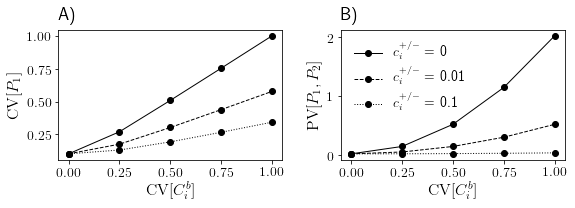

In [12]:
endpt = u_df[(u_df.index==1000)] # Where we get 'steady-state' value

plt.figure(figsize=(8,3))
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')

plt.subplot(1,2,1)
styles = ['-','--',':']
markers = ['o','o','o']
colors = ['black','black','black']
for idx,k in enumerate([0, 0.01, 0.1]):
    sub_endpt = endpt[(endpt['k']==k)]
    plt.plot(sub_endpt['std'],sub_endpt['CV(P0)'], linestyle = styles[idx], linewidth = 1,
             marker = markers[idx], label = '$c^{+/-}_i = $ '+str(k), color = colors[idx])
plt.xlabel('$\mathrm{CV}[C^b_i]$')
plt.ylabel('$\mathrm{CV}[P_1]$')
plt.title('A)', loc = 'left')
plt.subplot(1,2,2)
for idx,k in enumerate([0, 0.01, 0.1]):
    sub_endpt = endpt[(endpt['k']==k)]
    plt.plot(sub_endpt['std'],sub_endpt['Var(P0-P1)']/sub_endpt['P0']**2, linestyle = styles[idx], linewidth = 1,
             marker = markers[idx], label = '$c^{+/-}_i$ = '+str(k), color = colors[idx])
plt.xlabel('$\mathrm{CV}[C^b_i]$')
plt.ylabel('$\mathrm{PV}[P_1,P_2]$')
plt.legend(frameon = False, loc = 0)
plt.title('B)', loc = 'left')

plt.tight_layout()
plt.savefig('birthdeath_ex.eps', pad_inches=0)
plt.show()